In [1]:
# %matplotlib inline 可以在Ipython编译器里直接使用，功能是可以内嵌绘图，并且可以省略掉plt.show()这一步
%matplotlib inline 
import torch
import matplotlib.pyplot as plt
import random

## 生成数据集

为了简单起见，我们将根据带有噪声的线性模型构造一个人造数据集。
我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。
我们将使用低维数据，这样可以很容易地将其可视化。
在下面的代码中，我们生成一个包含1000个样本的数据集，
每个样本包含从标准正态分布中采样的2个特征。
我们的合成数据集是一个矩阵$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$。

使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$

$\epsilon$可以视为模型预测和标签时的潜在观测误差。
在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。
为了简化问题，我们将标准差设为0.01。
下面的代码生成合成数据集。


In [2]:
"""生成y=Xw+b+噪声"""
# 函数的输入变量中为什么不指定样本数据的维度？
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    # 除了torch.matmul中还有什么函数可以实现矩阵-向量相乘？ 
    # 使用mul/*可以吗，对应输出的张量尺寸又是怎样的？
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    # 转换成1列：.reshape((-1, 1))；转换成1行：.reshape((1, -1))
    # 可以使用labels.dim()查看tensor维度
    return X, y.reshape((-1, 1))

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

注意，`features`中的每一行都包含一个二维数据样本，`labels`中的每一行都包含一维标签值（一个标量）。

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([1.1129, 1.5995]) 
label: tensor([0.9931])


通过生成第二个特征`features[:, 1]`和`labels`的散点图，
可以直观观察到两者之间的线性关系。

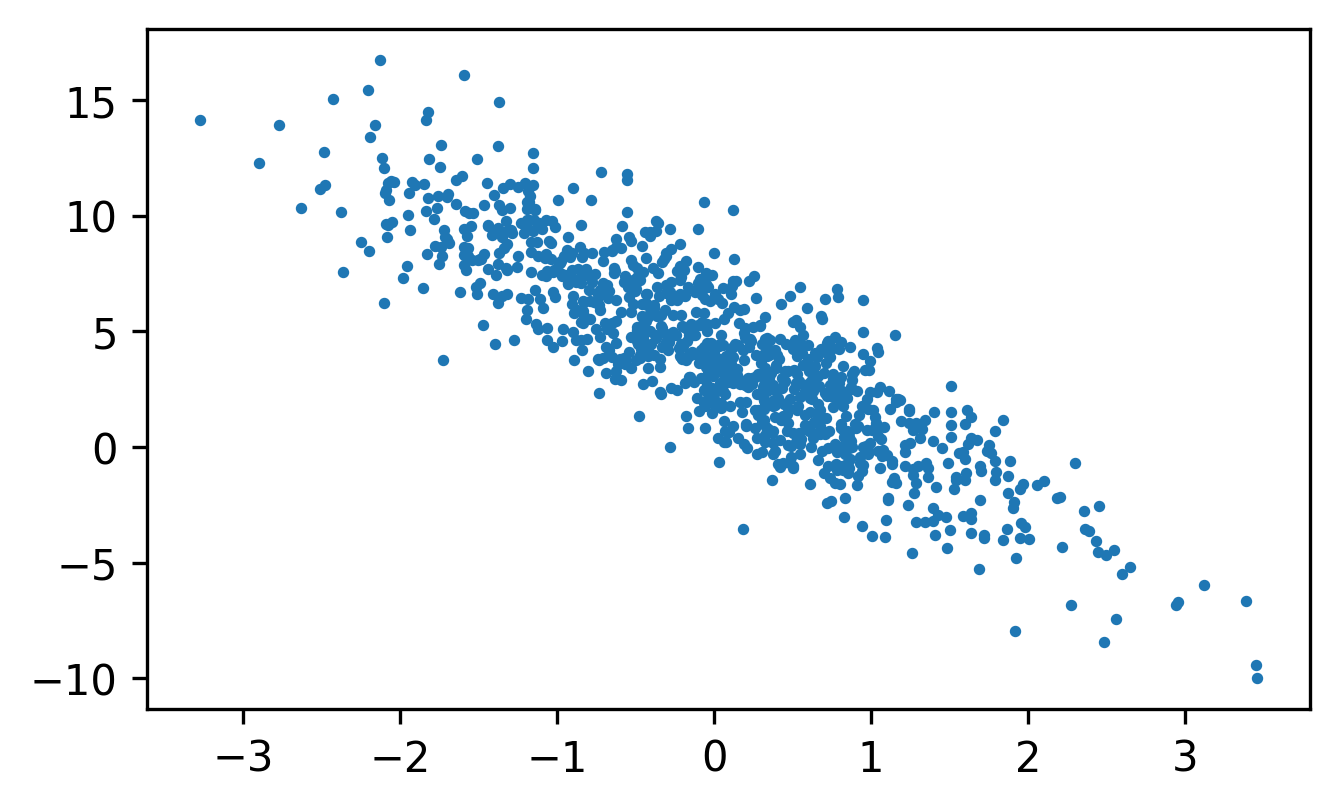

In [5]:
plt.figure(dpi=300,figsize=(5,3))
plt.scatter(features[:, 1], labels, s=3)
#plt.show()

## 读取数据集

训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。
由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数，
该函数能打乱数据集中的样本并以小批量方式获取数据。

在下面的代码中，我们定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量。
每个小批量包含一组特征和标签。


In [6]:
def data_iter(batch_size, features, labels):
    # len默认返回多维数组的第一个维度大小
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        # 获取某一批样本的索引，为什么要用一个min函数？
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        # yield函数和return函数的区别？
        yield features[batch_indices], labels[batch_indices]
#   return ....(位于循环的外部，待变量完全生成后一次性返回)

****************演示部分****************

In [7]:
A = list(range(5))
print(A)
random.shuffle(A)
print(A)

[0, 1, 2, 3, 4]
[4, 0, 1, 2, 3]


****************演示部分****************

In [8]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.7533, -1.0935],
        [-0.4369,  2.9533],
        [ 1.5528, -1.2043],
        [-0.5002,  2.9433],
        [-1.5265,  0.7387],
        [-0.3152,  0.3339],
        [-0.3487, -0.2217],
        [-1.5416, -0.3404],
        [ 1.8573,  0.2231],
        [ 0.9204, -1.0137]]) 
 tensor([[ 9.4175],
        [-6.7193],
        [11.4108],
        [-6.8325],
        [-1.3622],
        [ 2.4388],
        [ 4.2752],
        [ 2.2718],
        [ 7.1515],
        [ 9.4879]])


在我们开始用小批量随机梯度下降优化我们的模型参数之前，我们需要先有一些参数。
在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，
并将偏置初始化为0。

In [9]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 定义模型

In [10]:
def linreg(X, w, b):
    """线性回归模型"""
    # torch.matmul(X, w)输出是一个向量，为什么可以与标量b相加
    return torch.matmul(X, w) + b

## 定义损失函数

In [11]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法

\begin{split}\begin{aligned} \mathbf{w} &\leftarrow \mathbf{w} -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b)\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_b l^{(i)}(\mathbf{w}, b) \end{aligned}\end{split}

In [12]:
def sgd(params, lr, batch_size):
    # torch.no_grad()是一个上下文管理器，被该语句包裹起来的部分将不会追踪梯度
    with torch.no_grad():
        for param in params:
            # 对变量param进行了运算
            param -= lr * param.grad / batch_size
            param.grad.zero_()

****************演示部分****************

In [13]:
A = torch.tensor([1.1], requires_grad=True) 
B = A * 2 
B

tensor([2.2000], grad_fn=<MulBackward0>)

In [14]:
# in-place操作是直接改变给定张量的内容而不需要复制的运算。（不推荐）
B.add_(2)
print(B)
with torch.no_grad():
    B.mul_(2)
print(B)

tensor([4.2000], grad_fn=<AddBackward0>)
tensor([8.4000], grad_fn=<AddBackward0>)


****************演示部分****************

## 模型训练

In [15]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

# epoch是什么？
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    # 查看每次epoch后的损失函数情况
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.034490
epoch 2, loss 0.000130
epoch 3, loss 0.000052


In [16]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0005, 0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)
